<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

# Automated Essay Scoring 2.0 with [KerasNLP](https://github.com/keras-team/keras-nlp) and [Keras](https://github.com/keras-team/keras)

<div align="center">
    <img src="https://i.ibb.co/BrZf1MC/AESv2.jpg">
</div>

In this competition, our aim is to develop an AI model that can score student essays. This competition is actually an updated version of an old one that took place over a decade ago. In this version, we aim to improve upon essay scoring algorithms to enhance student learning outcomes. This notebook will guide you through the process of fine-tuning the **DebertaV3** model using **Ordinal Regression/Classification** to score student essays using KerasNLP.

**Did you know**: This notebook is backend-agnostic, which means it supports TensorFlow, PyTorch, and JAX backends. However, the best performance can be achieved with `JAX`. KerasNLP and Keras enable the choice of the preferred backend. Explore further details on [Keras](https://keras.io/keras_3/).

**Note**: For a deeper understanding of KerasNLP, refer to the [KerasNLP guides](https://keras.io/keras_nlp/).

In [1]:
# !pip install textstat

# 📚 | Import Libraries 

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # "jax" or "tensorflow" or "torch" 

import keras_nlp
import keras
import keras.backend as K
import tensorflow as tf

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl


# DEPENDENCIES FOR FEATURE ENGINEERING AND EDA (INSPO TAKEN FROM https://www.kaggle.com/code/tariqcp/understanding-aes-2-0-data-a-comprehensive-eda)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
# import textstat
import seaborn as sns

cmap = plt.get_cmap('coolwarm')

2024-05-19 18:14:52.850759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 18:14:52.850858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 18:14:52.973183: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Library Version

In [3]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.15.0
Keras: 3.2.1
KerasNLP: 0.9.3


# ⚙️ | Configuration

In [4]:
class CFG:
    seed = 42  # Random seed
    preset = "deberta_v3_extra_small_en" # Name of pretrained models
    sequence_length = 512  # Input sequence length
    epochs = 5 # Training epochs
    batch_size = 32  # Batch size
    scheduler = 'cosine'  # Learning rate scheduler

# ♻️ | Reproducibility 
Sets value for random seed to produce similar result in each run.

In [5]:
keras.utils.set_random_seed(CFG.seed)

# 🧮 | Mixed Precision

In [6]:
keras.mixed_precision.set_global_policy("mixed_float16")

# 📁 | Dataset Path 

In [7]:
BASE_PATH = '/kaggle/input/learning-agency-lab-automated-essay-scoring-2'

# 📖 | Meta Data

**Files in the dataset:**

- `{test|train}.csv`
  - `essay_id`: Unique identifier for each essay.
  - `full_text`: Essay text.
  - `score`: Essay's score from `1-6`.
- `sample_submission.csv`: Valid sample submission.

**What does the `score` mean?**

The `score` represents the quality of student-written argumentative essays. Essays were rated based on a rubric covering perspective development, critical thinking, evidence use, organization, language, and grammar/mechanics. Here's a summary of the scoring criteria:

| Score | Description |
|-------|-------------|
| 6     | Clear mastery with few errors, outstanding critical thinking, appropriate evidence, well-organized, skilled language use. |
| 5     | Reasonable mastery with occasional errors, strong critical thinking, generally appropriate evidence, well-organized, good language use. |
| 4     | Adequate mastery with some lapses, competent critical thinking, adequate evidence, generally organized, fair language use. |
| 3     | Developing mastery with weaknesses, limited critical thinking, inconsistent evidence, limited organization, fair language use with weaknesses. |
| 2     | Little mastery with serious flaws, weak critical thinking, insufficient evidence, poor organization, limited language use with frequent errors. |
| 1     | Very little or no mastery, severely flawed, no viable point of view, disorganized, fundamental language flaws, pervasive grammar/mechanics errors. |

> This grading is very similar to the grading used in the [ETS GRE (Graduate Record Examinations) AWA](https://www.ets.org/gre/test-takers/general-test/prepare/content/analytical-writing.html) exam, where prospective graduate students are asked to write essays to judge their analytical abilities, and their scores are later used for graduate admission. 


In [8]:
# Load data
df = pd.read_csv(f'{BASE_PATH}/train.csv')  # Read CSV file into a DataFrame

# Display information about the train data
print("# Train Data: {:,}".format(len(df)))
print("# Sample:")
display(df.head(2))

# Train Data: 17,307
# Sample:


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3


# 🔪 | Data Split

In the code snippet provided below, we will divide the existing **train** data into folds using a stratification of `label` column.

In [9]:
from sklearn.model_selection import train_test_split  # Import package

train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["score"])

# 🧂 | Process Labels for Ordinal Regression

**What is Ordinal Regression?**
Ordinal regression is a type of supervised learning algorithm used to predict an ordinal or ranked dependent variable. Unlike in typical classification problems where the target variable is categorical, in ordinal regression the target variable has a ordering or ranking. It is also different from typical regression, where the target variable is continuous. In ordinal regression, the target variable has a discrete, ordered set of values, such as levels of satisfaction or performance grades.

**Why do we need it?**
Ordinal regression is useful when the target variable (in our competition, the `score` of an essay) represents a ranking or order. Specifically, ordinal regression can capture the inherent order in the target variable, which standard classification models may not be able to do effectively.

For Ordinal Regression, we have to transform the labels, which is different from typical classification or regression. The following code will convert essay scores to an ordinal matrix, which will be used as the ground truth for calculating the loss.

In [10]:
def to_ordinal(y, num_classes=None, dtype="float32"):
    """Converts a class vector (integers) to an ordinal regression matrix.

    This utility encodes class vector to ordinal regression/classification
    matrix where each sample is indicated by a row and rank of that sample is
    indicated by number of ones in that row.

    Args:
        y: Array-like with class values to be converted into a matrix
            (integers from 0 to `num_classes - 1`).
        num_classes: Total number of classes. If `None`, this would be inferred
            as `max(y) + 1`.
        dtype: The data type expected by the input. Default: `'float32'`.

    Returns:
        An ordinal regression matrix representation of the input as a NumPy
        array. The class axis is placed last.
    """
    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    range_values = np.arange(num_classes - 1)
    range_values = np.tile(np.expand_dims(range_values, 0), [n, 1])
    ordinal = np.zeros((n, num_classes - 1), dtype=dtype)
    ordinal[range_values < np.expand_dims(y, -1)] = 1
    output_shape = input_shape + (num_classes - 1,)
    ordinal = np.reshape(ordinal, output_shape)
    return ordinal

In [11]:
scores = [1, 3, 5, 2, 6]

to_ordinal(scores)

array([[1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0.],
       [1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1.]], dtype=float32)

## Label Conversion

In [12]:
train_df["label"] = to_ordinal(train_df.score.values).tolist()
valid_df["label"] = to_ordinal(valid_df.score.values).tolist()

# 🎨 | EDA

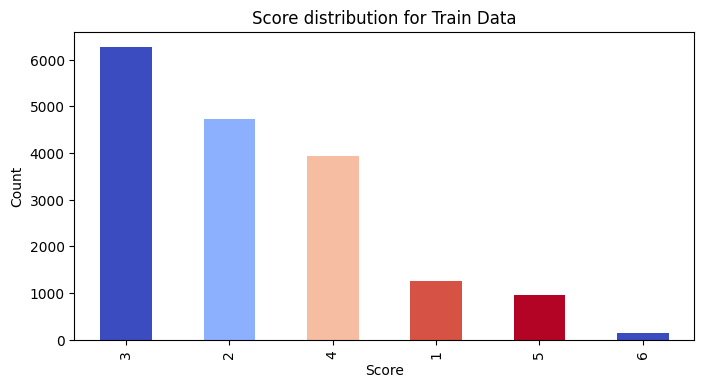

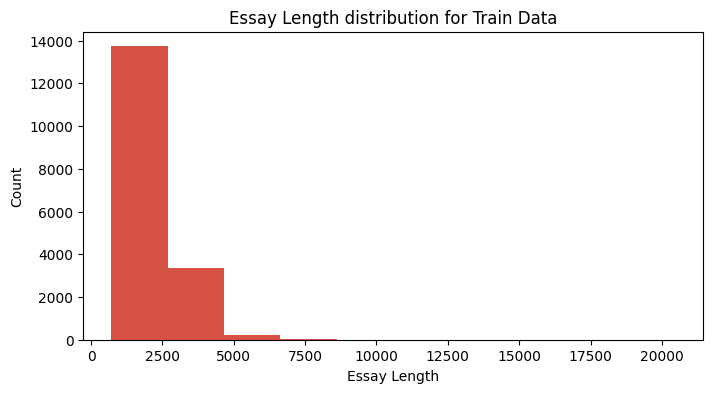

In [13]:
# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
df.score.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Score distribution for Train Data")
plt.show()

# Show distribution of essay length using a bar plot
plt.figure(figsize=(8, 4))
df['essay_length'] = df.full_text.map(len)
df.essay_length.plot.hist(logy=False, color=cmap(0.9))
plt.xlabel("Essay Length")
plt.ylabel("Count")
plt.title("Essay Length distribution for Train Data")
plt.show()

# Extra EDA

Apart from the default set EDA done by the competition organizers, I will conduct some additional methods to continue understanding the dataset.

It is surely important to understand features like essay length, the most frequent words used, if there is any correlation between the former two and the actual essay score, among others. Thus, I will try to delve into these aspects.

SOME INSPO TAKEN FROM: https://www.kaggle.com/code/tariqcp/understanding-aes-2-0-data-a-comprehensive-eda

In [14]:
# Initial EDA

print("Shape", train_df.shape,"\n")

# Distribution of the "score"

print("Distribution of essay scores")
print(train_df["score"].describe()) 

Shape (13845, 4) 

Distribution of essay scores
count    13845.000000
mean         2.948573
std          1.044910
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: score, dtype: float64


In [15]:
# Get essay feature

essays = train_df["full_text"]

# Function to split each essay
def count_words(essay):
    return len(essay.split())

words = essays.apply(count_words)

# Add essay length to train_df (both by characters and by words)

train_df["char_essay_length"] = essays.apply(len)
train_df["words_essay_length"] = words


In [16]:
print(train_df.head(2))

# Now, our df has some new features, like the essay length both in chars and words,
# As well as the ordinal matrix representation of the scores, which was
# computed following the guidelines in this notebook

      essay_id                                          full_text  score  \
14188  d0d5c01  Now a days you see everyone with cars driving ...      4   
13755  c9f4cf0  I think we should change the elction to popula...      2   

                                label  char_essay_length  words_essay_length  
14188  [1.0, 1.0, 1.0, 1.0, 0.0, 0.0]               3879                 732  
13755  [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]               1490                 254  


In [17]:
# Let's now understand the lengths

max_word_length = train_df["words_essay_length"].max()
min_word_length = train_df["words_essay_length"].min()
max_char_length = train_df["char_essay_length"].max()
min_char_length = train_df["char_essay_length"].min()

print("Max word length:", max_word_length, "," , "Min word length:", min_word_length)
print("Max char length:", max_char_length, "," , "Min char length:", min_char_length)

Max word length: 1656 , Min word length: 150
Max char length: 20459 , Min char length: 712


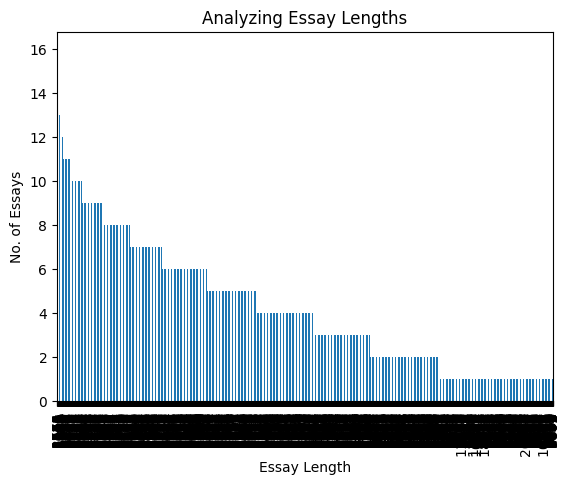

In [18]:
# Let's now visualize them
train_df['char_essay_length'].value_counts().plot(kind='bar')
plt.title('Analyzing Essay Lengths')
plt.xlabel('Essay Length')
plt.ylabel('No. of Essays')
plt.show()

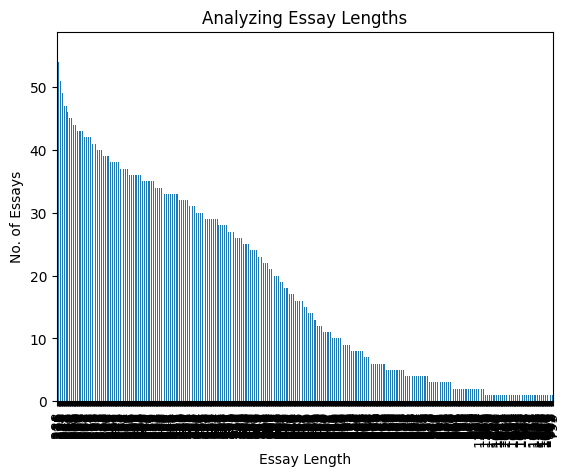

In [19]:

# Let's now visualize them
train_df['words_essay_length'].value_counts().plot(kind='bar')
plt.title('Analyzing Essay Lengths')
plt.xlabel('Essay Length')
plt.ylabel('No. of Essays')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


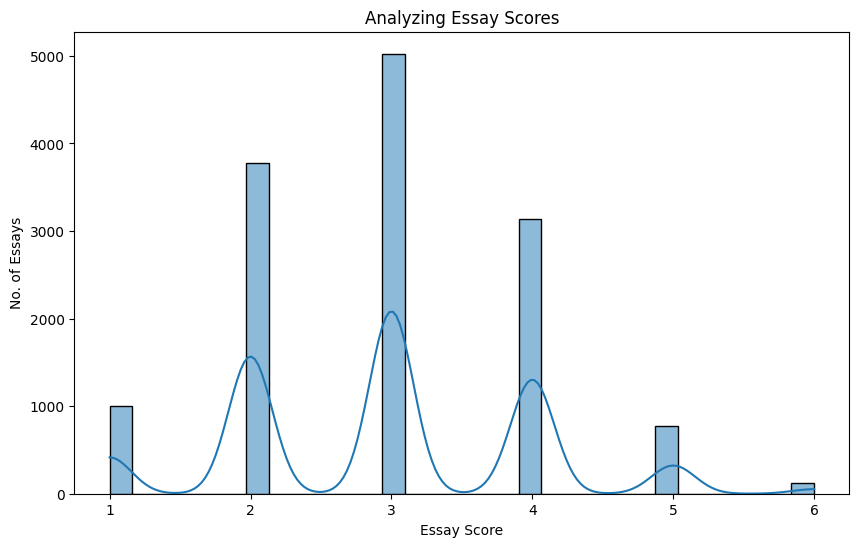

In [20]:
# We can see that there are almost clusters of character lengths forming
# Whilst the curve for words is much more smooth with less defined groups

# Let's now see the test score distribution

# Distribution plot of essay scores
plt.figure(figsize=(10, 6))
sns.histplot(train_df['score'], kde=True)
plt.title("Analyzing Essay Scores")
plt.xlabel("Essay Score")
plt.ylabel("No. of Essays")
plt.show()

In [21]:
# We can see that it almost looks like they follow a normal distribution.

# Let's see if there is any correlation between word length/char length and the
# scores

# Correlation between char essay length and scores
corr_matrix = train_df['score'].corr(train_df['char_essay_length'])
print("Correlation between Character Essay Length and Score:", corr_matrix)

# Correlation between word essay length and scores
corr_matrix = train_df['score'].corr(train_df['words_essay_length'])
print("Correlation between Word Essay Length and Score:", corr_matrix)

Correlation between Character Essay Length and Score: 0.6521325781747017
Correlation between Word Essay Length and Score: 0.6937548479505694


In [22]:
# We can see that the essay's length in words is more highly
# correlated to the score than the essay length in characters.

Sentiment Analysis:
Positive essays: 11001
Negative essays: 2842
Neutral essays: 2


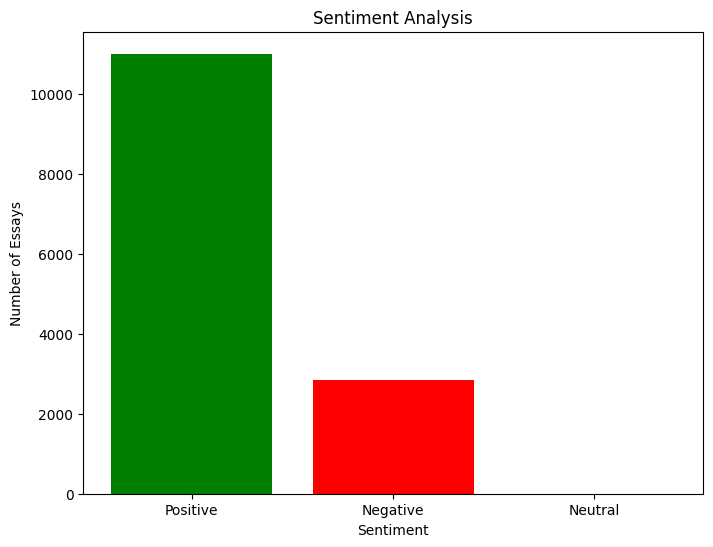

In [23]:
# Analyze Essay Sentiment (Taken from inspo notebook)

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Analyze the sentiment of each essay
sentiment_scores = []
for essay in essays:
    sentiment_scores.append(sid.polarity_scores(essay)['compound'])

# Add sentiment scores to the dataframe
train_df['sentiment_score'] = sentiment_scores

# Overall sentiment analysis
positive_count = sum(score > 0 for score in sentiment_scores)
negative_count = sum(score < 0 for score in sentiment_scores)
neutral_count = len(sentiment_scores) - positive_count - negative_count

print("Sentiment Analysis:")
print("Positive essays:", positive_count)
print("Negative essays:", negative_count)
print("Neutral essays:", neutral_count)

# Data for visualization
categories = ['Positive', 'Negative', 'Neutral']
counts = [positive_count, negative_count, neutral_count]

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['green', 'red', 'blue'])
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Number of Essays')
plt.show()

In [24]:
# There are a lot more positive than negative essays!
# Let's check the correlations with the scores

# Correlation between sentiment score and score -> VERY LOW (Maybe do feature engineering to store
# as a categorical var)
corr_matrix = train_df['score'].corr(train_df['sentiment_score'])
print("Correlation between Sentiment Score and Score:", corr_matrix)


Correlation between Sentiment Score and Score: 0.016222183279865403


In [25]:
# Analyze Readability (Taken from inspo)

# Analyzing readability scores for each essay
"""
readability_scores = []
for essay in essays:
    # Compute Flesch-Kincaid Grade Level
    fkg_score = textstat.flesch_kincaid_grade(essay)
    
    # Computing Gunning Fog Index
    gunning_fog_score = textstat.gunning_fog(essay)
    
    # Add scores to list
    readability_scores.append({'Flesch-Kincaid': fkg_score, 'Gunning Fog': gunning_fog_score})

# Creating a dataframe to store the scores
readability_df = pd.DataFrame(readability_scores)

# Create histograms for Flesch-Kincaid and Gunning Fog scores
plt.figure(figsize=(10, 6))
plt.hist(readability_df['Flesch-Kincaid'], bins=20, alpha=0.5, label='Flesch-Kincaid')
plt.hist(readability_df['Gunning Fog'], bins=20, alpha=0.5, label='Gunning Fog')
plt.title('Readability Scores Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()
# Display the dataframe
print(readability_df)

"""


"\nreadability_scores = []\nfor essay in essays:\n    # Compute Flesch-Kincaid Grade Level\n    fkg_score = textstat.flesch_kincaid_grade(essay)\n    \n    # Computing Gunning Fog Index\n    gunning_fog_score = textstat.gunning_fog(essay)\n    \n    # Add scores to list\n    readability_scores.append({'Flesch-Kincaid': fkg_score, 'Gunning Fog': gunning_fog_score})\n\n# Creating a dataframe to store the scores\nreadability_df = pd.DataFrame(readability_scores)\n\n# Create histograms for Flesch-Kincaid and Gunning Fog scores\nplt.figure(figsize=(10, 6))\nplt.hist(readability_df['Flesch-Kincaid'], bins=20, alpha=0.5, label='Flesch-Kincaid')\nplt.hist(readability_df['Gunning Fog'], bins=20, alpha=0.5, label='Gunning Fog')\nplt.title('Readability Scores Distribution')\nplt.xlabel('Score')\nplt.ylabel('Frequency')\nplt.legend()\nplt.show()\n# Display the dataframe\nprint(readability_df)\n\n"

In [26]:
# The correlations are low, but, there may be hidden non-linear correlations hidden in the data.
'''
corr_matrix = train_df['score'].corr(readability_df['Flesch-Kincaid'])
print("Correlation between FK Readability and Score:", corr_matrix)

corr_matrix = train_df['score'].corr(readability_df['Gunning Fog'])
print("Correlation between GF Readability and Score:", corr_matrix)
'''

'\ncorr_matrix = train_df[\'score\'].corr(readability_df[\'Flesch-Kincaid\'])\nprint("Correlation between FK Readability and Score:", corr_matrix)\n\ncorr_matrix = train_df[\'score\'].corr(readability_df[\'Gunning Fog\'])\nprint("Correlation between GF Readability and Score:", corr_matrix)\n'

In [27]:
# Final Train Df
'''
train_df["fkg_score"] = readability_df["Flesch-Kincaid"]
train_df["gf_score"] = readability_df["Gunning Fog"]

train_df.tail()'''

'\ntrain_df["fkg_score"] = readability_df["Flesch-Kincaid"]\ntrain_df["gf_score"] = readability_df["Gunning Fog"]\n\ntrain_df.tail()'

In [28]:
# Check nan_values
nan_values_count = train_df.isnull().sum()
print(nan_values_count)

rf_df = train_df.dropna()


essay_id              0
full_text             0
score                 0
label                 0
char_essay_length     0
words_essay_length    0
sentiment_score       0
dtype: int64


# 

In [29]:
# Te

# First Model of the Stack: Random Forest Classifier

Now, with all the engineered features, I will create a Random Forest Classifier to then stack it with the predictions of the Keras.


In [30]:
def calculate_essay_lengths(df, text_column):
    df['char_essay_length'] = df[text_column].apply(len)
    df['words_essay_length'] = df[text_column].apply(lambda x: len(x.split()))
    return df

def analyze_sentiment(df, text_column):
    # Initialize the sentiment analyzer
    sid = SentimentIntensityAnalyzer()
    
    # Analyze the sentiment of each essay
    sentiment_scores = df[text_column].apply(lambda x: sid.polarity_scores(x)['compound'])
    
    # Add sentiment scores to the dataframe
    df['sentiment_score'] = sentiment_scores
    
    # Overall sentiment analysis
    positive_count = sum(sentiment_scores > 0)
    negative_count = sum(sentiment_scores < 0)
    neutral_count = len(sentiment_scores) - positive_count - negative_count
    
    print("Sentiment Analysis:")
    print("Positive essays:", positive_count)
    print("Negative essays:", negative_count)
    print("Neutral essays:", neutral_count)
    
    # Data for visualization
    categories = ['Positive', 'Negative', 'Neutral']
    counts = [positive_count, negative_count, neutral_count]
    
    return df


'''
def analyze_readability(df, text_column):
    # Analyzing readability scores for each essay
    readability_scores = []
    for essay in df[text_column]:
        # Compute Flesch-Kincaid Grade Level
        fkg_score = textstat.flesch_kincaid_grade(essay)
        
        # Compute Gunning Fog Index
        gunning_fog_score = textstat.gunning_fog(essay)
        
        # Add scores to list
        readability_scores.append({'Flesch-Kincaid': fkg_score, 'Gunning Fog': gunning_fog_score})
    
    # Creating a dataframe to store the scores
    readability_df = pd.DataFrame(readability_scores)
    
    print(readability_df)
    
    return readability_df
'''

"\ndef analyze_readability(df, text_column):\n    # Analyzing readability scores for each essay\n    readability_scores = []\n    for essay in df[text_column]:\n        # Compute Flesch-Kincaid Grade Level\n        fkg_score = textstat.flesch_kincaid_grade(essay)\n        \n        # Compute Gunning Fog Index\n        gunning_fog_score = textstat.gunning_fog(essay)\n        \n        # Add scores to list\n        readability_scores.append({'Flesch-Kincaid': fkg_score, 'Gunning Fog': gunning_fog_score})\n    \n    # Creating a dataframe to store the scores\n    readability_df = pd.DataFrame(readability_scores)\n    \n    print(readability_df)\n    \n    return readability_df\n"

In [31]:
calculate_essay_lengths(valid_df, 'full_text')

valid_essays = valid_df['full_text']

analyze_sentiment(valid_df, 'full_text')

'''
valid_readability_df = analyze_readability(valid_df, 'full_text')
valid_df["fkg_score"] = valid_readability_df["Flesch-Kincaid"]
valid_df["gf_score"] = valid_readability_df["Gunning Fog"]
'''

valid_rf_df = valid_df.dropna()

Sentiment Analysis:
Positive essays: 2746
Negative essays: 716
Neutral essays: 0


In [32]:
valid_rf_df = valid_df.dropna()

# 🍽️ | Preprocessing

**What it does:** The preprocessor takes input strings and transforms them into a dictionary (`token_ids`, `padding_mask`) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important:** Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming `"The quick brown fox"` into `["the", "qu", "##ick", "br", "##own", "fox"]`, we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

Explore the following pages to access the available preprocessing and tokenizer layers in **KerasNLP**:
- [Preprocessing](https://keras.io/api/keras_nlp/preprocessing_layers/)
- [Tokenizers](https://keras.io/api/keras_nlp/tokenizers/)

In [33]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...


Now, let's examine what the output shape of the preprocessing layer looks like. The output shape of the layer can be represented as $(num\_choices, sequence\_length)$.

In [34]:
inp = preprocessor(df.full_text.iloc[0])  # Process text for the first row

# Display the shape of each processed output
for k, v in inp.items():
    print(k, ":", v.shape)

token_ids : (512,)
padding_mask : (512,)


We'll use the `preprocessing_fn` function to transform each text option using the `dataset.map(preprocessing_fn)` method.

In [35]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

# 🍚 | DataLoader

The code below sets up a robust data flow pipeline using `tf.data.Dataset` for data processing. Notable aspects of `tf.data` include its ability to simplify pipeline construction and represent components in sequences.

To learn more about `tf.data`, refer to this [documentation](https://www.tensorflow.org/guide/data).

In [36]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=True, drop_remainder=True,
                  shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds

## Build Train/Valid Dataset

The function below generates the training and validation datasets.

In [37]:
# Train Data
train_texts = train_df.full_text.tolist()  # Extract training texts
train_labels = np.array(train_df.label.tolist())  # Extract training labels

# Build training dataset
train_ds = build_dataset(
    train_texts, train_labels, batch_size=CFG.batch_size, shuffle=True
)

# Valid Data
valid_texts = valid_df.full_text.tolist()  # Extract validation texts
valid_labels = np.array(valid_df.label.tolist())  # Extract validation labels

# Build validation dataset
valid_ds = build_dataset(
    valid_texts, valid_labels, batch_size=CFG.batch_size, shuffle=False
)


# ⚓ | LR Schedule

Implementing a learning rate scheduler is crucial for transfer learning. The learning rate initiates at `lr_start` and gradually tapers down to `lr_min` using various techniques, including:
- `step`: Lowering the learning rate in step-wise manner resembling stairs.
- `cos`: Utilizing a cosine curve to gradually reduce the learning rate.
- `exp`: Exponentially decreasing the learning rate.

**Importance:** A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [38]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-5, 0.3e-5 * batch_size, 0.3e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

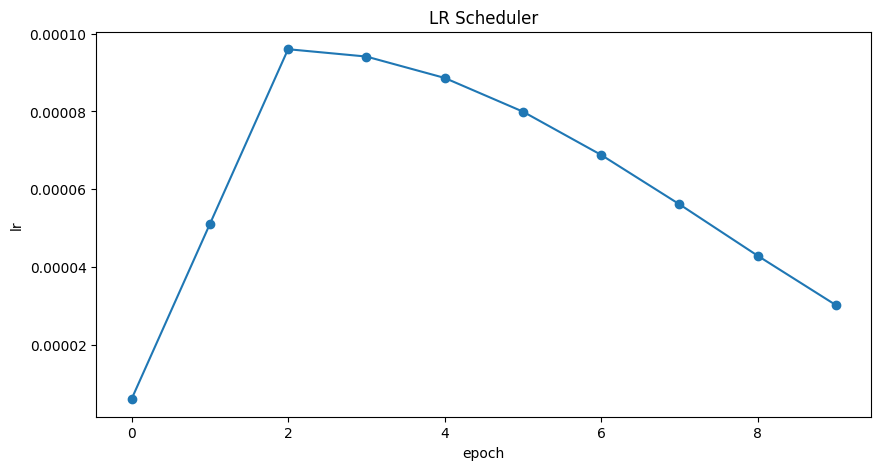

In [39]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

# 💾 | Model Checkpointing

The following code will create a callback that will save the best checkpoint of the model during training, which we will use for inference in the submission.

In [40]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.weights.h5",
    monitor="val_weighted_kappa",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
)


# 📏 | Metric

The metric for this competition is quadratic **Weighted Kappa**. This metric is particularly useful for tasks involving ordinal classification (where labels have inherent order). The following code implements this metric from scratch. This metric is implemented taking inspiration from [this TensorFlow implementation](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/WeightedKappaLoss). You can learn more about this metric [here](https://www.sciencedirect.com/science/article/abs/pii/S0167865517301666). 

> This metric implementation is a bit different than the competition metric, which was resolved by @taichiuemura in [here](https://www.kaggle.com/code/taichiuemura/aes-2-0-kerasnlp-starter/#%F0%9F%93%8F-%7C-Metric).

In [41]:
class WeightedKappa(keras.metrics.Metric):
    def __init__(self, num_classes=6, epsilon=1e-6):
        super().__init__(name="weighted_kappa")
        self.num_classes = num_classes
        self.epsilon = epsilon

        label_vec = keras.ops.arange(num_classes, dtype=keras.backend.floatx())
        self.row_label_vec = keras.ops.reshape(label_vec, [1, num_classes])
        self.col_label_vec = keras.ops.reshape(label_vec, [num_classes, 1])
        col_mat = keras.ops.tile(self.col_label_vec, [1, num_classes])
        row_mat = keras.ops.tile(self.row_label_vec, [num_classes, 1])
        self.weight_mat = (col_mat - row_mat) ** 2

        self.numerator = self.add_weight(name="numerator", initializer="zeros")
        self.denominator = self.add_weight(name="denominator", initializer="zeros")
        self.o_sum = self.add_weight(name = 'o_sum', initializer = 'zeros')
        self.e_sum = self.add_weight(name = 'e_sum', initializer = 'zeros')

    def update_state(self, y_true, y_pred, **args):
        # revert ordinal regression labels to classification labels
        y_true = keras.ops.one_hot(keras.ops.sum(y_true, axis=-1) - 1, 6)
        y_pred = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_pred > 0.5, dtype="int8"), axis=-1) - 1, 6
        )
        # weighted kappa calculation
        y_true = keras.ops.cast(y_true, dtype=self.col_label_vec.dtype)
        y_pred = keras.ops.cast(y_pred, dtype=self.weight_mat.dtype)
        batch_size = keras.ops.shape(y_true)[0]

        cat_labels = keras.ops.matmul(y_true, self.col_label_vec)
        cat_label_mat = keras.ops.tile(cat_labels, [1, self.num_classes])
        row_label_mat = keras.ops.tile(self.row_label_vec, [batch_size, 1])

        weight = (cat_label_mat - row_label_mat) ** 2

        self.numerator.assign_add(keras.ops.sum(weight * y_pred))
        label_dist = keras.ops.sum(y_true, axis=0, keepdims=True)
        pred_dist = keras.ops.sum(y_pred, axis=0, keepdims=True)
        w_pred_dist = keras.ops.matmul(
            self.weight_mat, keras.ops.transpose(pred_dist, [1, 0])
        )
        self.denominator.assign_add(
            keras.ops.sum(keras.ops.matmul(label_dist, w_pred_dist))
        )
        
        self.o_sum.assign_add(keras.ops.sum(y_pred))
        self.e_sum.assign_add(keras.ops.sum(
            keras.ops.matmul(keras.ops.transpose(label_dist, [1, 0]), pred_dist)
        ))

    def result(self):
        return 1.0 - (
            keras.ops.divide_no_nan(self.numerator, self.denominator)
            * keras.ops.divide_no_nan(self.e_sum, self.o_sum)
        )

    def reset_state(self):
        self.numerator.assign(0)
        self.denominator.assign(0)
        self.o_sum.assign(0)
        self.e_sum.assign(0)


# 🤖 | Modeling



## KerasNLP Classifier

The `KerasNLP` library provides comprehensive, ready-to-use implementations of popular NLP model architectures. It features a variety of pre-trained models including `Bert`, `Roberta`, `DebertaV3`, and more. In this notebook, we'll showcase the usage of `DebertaV3`. However, feel free to explore all available models in the [KerasNLP documentation](https://keras.io/api/keras_nlp/models/). Also, for a deeper understanding of `KerasNLP`, refer to the informative [getting started guide](https://keras.io/guides/keras_nlp/getting_started/).

Our approach involves using `keras_nlp.models.DebertaV3Classifier` to process each text and generate logits. These logits are passed through a `sigmoid` function to produce the final output.

> Note that we are tackling this problem as an **ordinal regression** problem, thus we have used `sigmoid` activation, but we can also consider this problem as a classification problem; then, we would've used `num_classes=6`, `softmax` activation, and `categorical_crossentropy` loss. We could even consider this as a **regression** problem with `num_classes=1`, `no activation` layer, and regression losses like MSE, MAE, etc. You are welcome to experiment with the typical classification and regression methods.

In [42]:
# Create a DebertaV3Classifier model
classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
    CFG.preset, preprocessor=None, num_classes=6
)
inputs = classifier.input
logits = classifier(inputs)

# Compute final output
outputs = keras.layers.Activation("sigmoid")(logits)

# Build Model
model = keras.Model(inputs, outputs)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(5e-6),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        WeightedKappa()
    ],
)
model.summary()


Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/deberta_v3/keras/deberta_v3_extra_small_en/2' to your Kaggle notebook...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_classif… │ (None, 6)         │ 70,832,262 │ padding_mask[0][… │
│ (DebertaV3Classifi… │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 6)         │          0 │ deberta_v3_class… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,832,262 (270.20 MB)

 Trainable params: 70,832,262 (270.20 MB)

 Non-trainable params: 0 (0.00 B)

# 🚂 | Training

Following code will train the model on the training dataset and evaluate on the validation dataset.

In [43]:
# Start training the model
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=[lr_cb, ckpt_cb]
)

Epoch 1/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 464s 1000ms/step - loss: 0.4975 - weighted_kappa: 0.1241 - val_loss: 0.2140 - val_weighted_kappa: 0.6515 - learning_rate: 6.0000e-06
Epoch 2/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 428s 991ms/step - loss: 0.1963 - weighted_kappa: 0.6853 - val_loss: 0.1680 - val_weighted_kappa: 0.7518 - learning_rate: 5.1000e-05
Epoch 3/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 424s 981ms/step - loss: 0.1647 - weighted_kappa: 0.7419 - val_loss: 0.1695 - val_weighted_kappa: 0.7660 - learning_rate: 9.6000e-05
Epoch 4/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 415s 959ms/step - loss: 0.1451 - weighted_kappa: 0.7896 - val_loss: 0.1720 - val_weighted_kappa: 0.7441 - learning_rate: 9.4116e-05
Epoch 5/5
432/432 ━━━━━━━━━━━━━━━━━━━━ 413s 955ms/step - loss: 0.1245 - weighted_kappa: 0.8249 - val_loss: 0.1624 - val_weighted_kappa: 0.7556 - learning_rate: 8.8618e-05


## Result Summary

In [44]:
# Find the epoch with the best validation accuracy
best_epoch = np.argmax(model.history.history['val_weighted_kappa'])
best_score = model.history.history['val_weighted_kappa'][best_epoch]
best_loss = model.history.history['val_loss'][best_epoch]

# Print and display best results
print(f'\n{"=" * 17} RESULTS {"=" * 17}')
print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Score : {best_score:.3f}\n>>>> BEST Epoch : {best_epoch}')
print('=' * 50)


================= RESULTS =================
>>>> BEST Loss  : 0.170
>>>> BEST Score : 0.766
>>>> BEST Epoch : 2


# Stacking

# 🧪 | Testing

In this section, we will visually test how our model performs on some samples from the validation data.

> Note that we are converting the ordinal regression model outputs with `sum`, unlike a typical classification problem where we would use `argmax`.

In [45]:
# Load best checkpoint
model.load_weights("best_model.weights.h5")

# Make predictions using the trained model on last validation data
valid_preds = model.predict(valid_ds, verbose=0)

# Format predictions and true answers
pred_scores = np.sum((valid_preds > 0.5).astype(int), axis=-1)
true_scores = valid_df.score.values

# Check 5 Predictions
print("# Predictions\n")
for i in range(5):
    row = valid_df.iloc[i]
    text = row.full_text
    pred_answer = pred_scores[i]
    true_answer = true_scores[i]
    print(f"❓ Text {i+1}:\n{text[:150]} .... {text[-150:]}\n")
    print(f"✅ True: {true_answer}\n")
    print(f"🤖 Predicted: {pred_answer}\n")
    print("-" * 90, "\n")


# Predictions

❓ Text 1:
Venus, Future planet earth?

Should we take more risks and stop being limited by danger and doubts? I think that the author give such good information ....  about Venus and also about why it's a good idea to start studying this planet. We have to start meeting the very edges of imagination and innovation.

✅ True: 3

🤖 Predicted: 2

------------------------------------------------------------------------------------------ 

❓ Text 2:
Joining this prgram was the best. There was a few incidents that happened while I was on this trip, but it was an amazing experience.

When I was on t .... n the ocean instead of being afraid to go because of sea sick and stuff. Itll be alot of fun if people go. They will enjoy thereselves and be alright.

✅ True: 3

🤖 Predicted: 3

------------------------------------------------------------------------------------------ 

❓ Text 3:
Have you ever wonder if you car was safe? What if you were causing enviornmental damage? Would you 

# 📬 | Submission

In this section, we will infer our model on the test data and then finally prepare the submission file.

## Build Test Dataset

In [46]:
# # Train Data
test_df = pd.read_csv(f"{BASE_PATH}/test.csv")
test_texts = test_df.full_text.fillna("").tolist()  # Extract training texts

# Build training dataset
test_ds = build_dataset(
    test_texts,
    labels=None,
    batch_size=min(CFG.batch_size, len(test_df)),
    shuffle=False,
    drop_remainder=False,  # include all samples
)


## Inference on Test Data

In [47]:
# Do inference
test_preds = model.predict(test_ds, verbose=1)

# Convert probabilities to class labels
test_preds = np.sum((test_preds>0.5).astype(int), axis=-1).clip(1, 6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


# Inference on Original Dataset

In [48]:
# Do inference
train_preds = model.predict(train_ds, verbose=1)

# Convert probabilities to class labels
train_preds = np.sum((test_preds>0.5).astype(int), axis=-1).clip(1, 6)

432/432 ━━━━━━━━━━━━━━━━━━━━ 126s 292ms/step


# Stacking

In [49]:
# Generate Random Forest Predictions on RF + NLP



In [50]:
print(test_df.head())

  essay_id                                          full_text
0  000d118  Many people have car where they live. The thin...
1  000fe60  I am a scientist at NASA that is discussing th...
2  001ab80  People always wish they had the same technolog...


In [51]:
final_train = train_df

In [52]:

final_train["nlp_preds"] = train_preds
final_train.head()

,essay_id,full_text,score,label,char_essay_length,words_essay_length,sentiment_score,nlp_preds
14188,d0d5c01,Now a days you see everyone with cars driving ...,4,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0]",3879,732,0.9958,3
13755,c9f4cf0,I think we should change the elction to popula...,2,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1490,254,0.9930,3
11928,af388ed,Are you interested in traveling? Are you inter...,3,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0]",2245,436,0.9974,3
373,06673c8,"In the article ""Driverless Cars are Coming"" th...",4,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0]",3459,628,0.9874,3
15412,e2f5624,Classrooms in this time period are filled with...,6,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",5521,939,0.9962,3


In [53]:
calculate_essay_lengths(test_df, 'full_text')

analyze_sentiment(test_df, 'full_text')

'''
test_readability_df = analyze_readability(test_df, 'full_text')
test_df["fkg_score"] = test_readability_df["Flesch-Kincaid"]
test_df["gf_score"] =test_readability_df["Gunning Fog"]
'''

test_df.head()

Sentiment Analysis:
Positive essays: 2
Negative essays: 1
Neutral essays: 0


,essay_id,full_text,char_essay_length,words_essay_length,sentiment_score
0,000d118,Many people have car where they live. The thin...,2677,498,0.9937
1,000fe60,I am a scientist at NASA that is discussing th...,1669,332,0.7705
2,001ab80,People always wish they had the same technolog...,3077,550,-0.9731


In [54]:
test_df["nlp_preds"] = test_preds

In [55]:
# RANDOM FOREST META LEARNER: NEURAL NETWORK NLP STACKING + FEATURE ENGINEERING

# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

# Define the model
model = RandomForestClassifier(n_estimators=100, random_state=CFG.seed)

# Define the features and target
features = final_train.drop(['score', 'essay_id', 'full_text', 'label'], axis=1)
target = final_train['score']

# Fit the model
model.fit(features, target)

# Get the feature importances
feature_importances = model.feature_importances_

# Test the model on the validation set
test_features = test_df.drop(['essay_id', 'full_text'], axis=1)
predictions = model.predict(test_features)

print(predictions)



[3 3 4]


# Stacking

In [56]:
print(test_df)

  essay_id                                          full_text  \
0  000d118  Many people have car where they live. The thin...   
1  000fe60  I am a scientist at NASA that is discussing th...   
2  001ab80  People always wish they had the same technolog...   

   char_essay_length  words_essay_length  sentiment_score  nlp_preds  
0               2677                 498           0.9937          2  
1               1669                 332           0.7705          2  
2               3077                 550          -0.9731          5  


## Create Submission File

In [57]:
# Create a DataFrame to store the submission
sub_df = test_df[["essay_id"]].copy()

# Add the formatted predictions to the submission DataFrame
sub_df["score"] = predictions

# Save Submission
sub_df.to_csv('submission.csv',index=False)

# Display the first 2 rows of the submission DataFrame
sub_df

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4


In [58]:
import tensorflow as tf

# List available physical devices
devices = tf.config.list_physical_devices('GPU')
print("GPUs:", devices)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# ✍️ | Reference
* [LLM Science Exam: KerasCore + KerasNLP [TPU]](https://www.kaggle.com/code/awsaf49/llm-science-exam-kerascore-kerasnlp-tpu)
* [Keras NLP](https://keras.io/api/keras_nlp/)
* [Triple Stratified KFold with TFRecords](https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords) by @cdeotte